In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker

from scipy.signal import hilbert

import pandas as pd

import py.continuum1d as continuum1d
c1d = continuum1d.continuum1d()

from py.params import setParams
from py.analysis import computeFPs, checkFixPtsStability, violationType, a_jkValues, lmbd
from py.turings import checkStability
from py.funcs import getSwitchIndex

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

1d Model initialised.


In [2]:
# explicit function to normalize array (for visualisation reasons - very helpful!)
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

In [3]:
b_lats = pd.read_csv('phase_lats/ee047_ii001_b.csv')
tau_lats = pd.read_csv('phase_lats/ee047_ii001_tau.csv')

In [4]:
ee = 0.47
ii = 0.01

params={'I_e': ee, 'I_i': ii, 'b': 0.25, 'end_t': 15*1000, 'mu_a': 0.4, 'beta_a': 10, 'n': 256, 'tau_a': 600}

ps = setParams(params)
fps = computeFPs(ps)
stab = checkFixPtsStability(fps, ps)

k=np.linspace(-3,3,51)

a_ee, a_ei, a_ie, a_ii = a_jkValues(fps[-1], ps)

print('fixed points %s ' %str(fps))
print('with (mass) stability %s'  %str(stab))

fp = fps[0]
checkStability(k, fp, ps)

fixed points [[0.12140373 0.47685033]
 [0.97653778 0.99999139]] 
with (mass) stability [1, 1]


(1, 1, 0)

In [5]:
ue, ui = c1d.run(ps, itype='inte_adaptation', fp=fp)

In [6]:
cmap = 'viridis'
fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=160)

start = 10 * 1000 * 10
duration = 4 * 1000 * 10

time = np.linspace(0, duration/(1000*10), 5)

space=np.linspace(-25, 25, 5)

pos = ax.imshow(ue.T[:,-start:-(start-duration)], vmin=0, vmax=1, aspect='auto', cmap=cmap)
colors = ['black', 'dimgray', 'silver']

ax.scatter(ps.time[2000]*10, ps.n/2, s=150, facecolors='white', edgecolors='black', zorder=1)
ax.plot(np.linspace(ps.time[2000]*10, ps.time[2000]*10, len(ps.x)), 
        np.linspace(0, ps.n-1, ps.n), c='white', ls='solid', lw=3, zorder=0)

ax.quiver(ps.time[2000]*10, ps.n/2, ps.time[2000]*10+1164, 0, color='orange',
          angles='xy', scale_units='xy', scale=1, width=0.008, zorder=2)
ax.quiver(ps.time[2000]*10, ps.n/2, 0, +21, color='turquoise',
          angles='xy', scale_units='xy', scale=1, width=0.008, zorder=2)
ax.quiver(ps.time[2000]*10, ps.n/2, +2186, +21, color='blue',
          angles='xy', scale_units='xy', scale=1, width=0.008, zorder=2)


ax.set_title(label=r'$u_e$' + ' for (i), i.e. ' + r'$I_e=0.47,\ I_i=0.01$', fontsize=15)

cbar_ticks=np.linspace(0,1,4)
cb_ax = fig.add_axes([.93,.126,.04,.754])
cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
cbar.ax.set_ylabel(r'$u_e$', rotation=-90, va="bottom", fontsize=15)
cbar.ax.set_yticklabels([0, 0.33, 0.66, 1])



#set x-axis labels
ax.set_xlabel('time', fontsize=10)
ax.xaxis.set_major_locator(ticker.LinearLocator(5))
ax.set_xticklabels(labels=time, fontsize=10)

#set y-axis labels
ax.set_ylabel('space', fontsize=10)
ax.yaxis.set_major_locator(ticker.LinearLocator(5))
ax.set_yticklabels(labels=space, fontsize=10)

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1956/4071605208.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=time, fontsize=10)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1956/4071605208.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=space, fontsize=10)


[Text(0, -0.5, '-25.0'),
 Text(0, 63.5, '-12.5'),
 Text(0, 127.5, '0.0'),
 Text(0, 191.5, '12.5'),
 Text(0, 255.5, '25.0')]

In [7]:
phase_latencies[int(ps.n/2)]

NameError: name 'phase_latencies' is not defined

In [9]:
node = int(ps.n/2)+2
act = ue.T[node, -start:-(start-duration)] #cut out the interval that's also shown
#act = activity.T[node]

In [10]:
from py.funcs import hilbert_trafo_nd, inst_phase

signal = hilbert_trafo_nd(act, axis=0)
phases = inst_phase(signal)

phases_cut = phases[20000:] #take the phases from time point onwards white line in activity plot
print(len(phases_cut.T), len(phases_cut))

#transform into complex space for visualisation reasons
complex_vector = np.exp(1j * phases_cut)
    
# Extract real and imaginary components of the complex vectors
real_part = np.real(complex_vector)
imaginary_part = np.imag(complex_vector)

20000 20000


In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=160)

ax.set_title(label='Phase '+ r'$\Phi(n,t)$'+ ' in ' + r'$\mathbb{C}$'+ ' of node ' + r'$n$' + 
             '\n' + 'until phase crossing at ' + r'$t_K$', fontsize=15)

ax.plot(real_part, imaginary_part, zorder=1)
ax.plot(np.linspace(-0.2,1.2,len(real_part)), np.linspace(0,0,len(real_part)), c='black', lw=1)
ax.plot(np.linspace(-0,0,len(imaginary_part)), np.linspace(-1.2,1.2,len(imaginary_part)), c='black', lw=1)

ax.scatter(real_part[0], imaginary_part[0], 
           facecolors='white', edgecolors='black', zorder=2, s=150)


nmb_nodes = np.linspace(100, 1300, 13).astype(int)

ax.scatter(real_part[nmb_nodes], imaginary_part[nmb_nodes], 
           facecolors='orange', edgecolors='black', zorder=2, s=150)


ax.scatter(real_part[int(nmb_nodes[-1]+80)], imaginary_part[int(nmb_nodes[-1]+80)], 
           facecolors='orange', edgecolors='red', zorder=2, s=150)

ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-1.2, 1.2])


#set x-axis labels
ax.set_xlabel(r'$real(e^{i\Phi(n,t)})$', fontsize=15)
ax.xaxis.set_major_locator(ticker.LinearLocator(8))
ax.set_xticklabels(labels=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], fontsize=15)

#set y-axis labels
ax.set_ylabel(r'$imag(e^{i\Phi(n,t)})$', fontsize=15)
ax.yaxis.set_major_locator(ticker.LinearLocator(7))
ax.set_yticklabels(labels=[-1.2, -1.8, -0.4, 0.0, 0.4, 0.8, 1.2], fontsize=15)

ax.text(real_part[0]-0.02, imaginary_part[0]+0.1, r'$t_0$')
ax.text(real_part[int(nmb_nodes[-1]+80)]-0.1, imaginary_part[int(nmb_nodes[-1]+80)]+0.04, r'$t_K$', c='r')

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1956/2037936140.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], fontsize=15)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1956/2037936140.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=[-1.2, -1.8, -0.4, 0.0, 0.4, 0.8, 1.2], fontsize=15)


Text(0.7875394927531154, -0.42073164510758615, '$t_K$')

In [12]:
signal = hilbert_trafo_nd(ue, axis=0)
phases = inst_phase(signal)
print(phases.shape)
phases_cut = phases[-80000:,:]

phase_latencies=np.zeros(len(phases_cut.T))
print(phase_latencies.shape)

for idx, node in enumerate(phases_cut.T):
    complex_vector = np.exp(1j * node)
    
    # Extract real and imaginary components of the complex vectors
    real_part = np.real(complex_vector)
    imaginary_part = np.imag(complex_vector)
    
    how_many_time_steps = getSwitchIndex(imaginary_part)
    #print(how_many_time_steps[0])
    phase_latencies[idx] = how_many_time_steps[0]

(150001, 256)
(256,)


In [13]:
times = np.linspace(0, max(phase_latencies), 5)
times

array([   0.  ,  541.25, 1082.5 , 1623.75, 2165.  ])

In [14]:
max(phase_latencies)

2165.0

In [15]:
from py.funcs import normalize

In [16]:
phase_latencies_norm = normalize(phase_latencies, 0, 1)

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1956/962949348.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=space, fontsize=15)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1956/962949348.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=times.astype(int), fontsize=15)


[Text(0, -107.2, '0'),
 Text(0, 487.8999999999999, '541'),
 Text(0, 1082.9999999999998, '1082'),
 Text(0, 1678.0999999999997, '1623'),
 Text(0, 2273.2, '2165')]

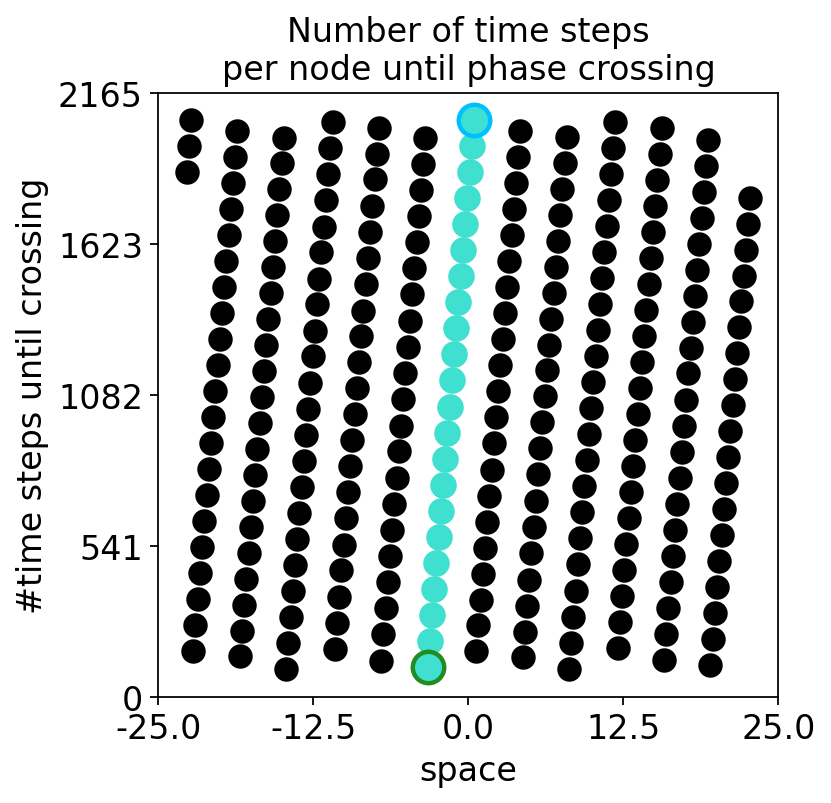

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=160)

low = 109
high = 131

ax.set_title(label='Number of time steps' + '\n' + 'per node until phase crossing', fontsize=15)

ax.scatter(np.linspace(-25,25, ps.n), phase_latencies, c='black', zorder=0, s=100)
ax.scatter(np.linspace(-25,25, ps.n)[low:high], phase_latencies[low:high], c='turquoise', zorder=1, s=120)
ax.scatter(np.linspace(-25,25, ps.n)[low], phase_latencies[low], 
           c='turquoise', edgecolor='forestgreen', zorder=2, s=200, lw=2)
ax.scatter(np.linspace(-25,25, ps.n)[high-1], phase_latencies[high-1], 
           c='turquoise', edgecolor='deepskyblue', zorder=2, s=200, lw=2)

#set x-axis labels
ax.set_xlabel('space', fontsize=15)
ax.xaxis.set_major_locator(ticker.LinearLocator(5))
ax.set_xticklabels(labels=space, fontsize=15)

#set y-axis labels
ax.set_ylabel('#time steps until crossing', fontsize=15)
ax.yaxis.set_major_locator(ticker.LinearLocator(5))
ax.set_yticklabels(labels=times.astype(int), fontsize=15)

In [19]:
phase_latencies[low], phase_latencies[high-1]

(8.0, 2165.0)

In [20]:
phase_latencies[low-21]

34.0

In [33]:
space_ticks = np.linspace(0, (ps.length/ps.n)*25,6).round(decimals=2)
space_ticks[::-1]

array([4.88, 3.91, 2.93, 1.95, 0.98, 0.  ])

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1956/1972827633.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0, 600, 1200, 1800, 2400], fontsize=15)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1956/1972827633.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=space_ticks[::-1], fontsize=15)


(-25.0, 0.0)

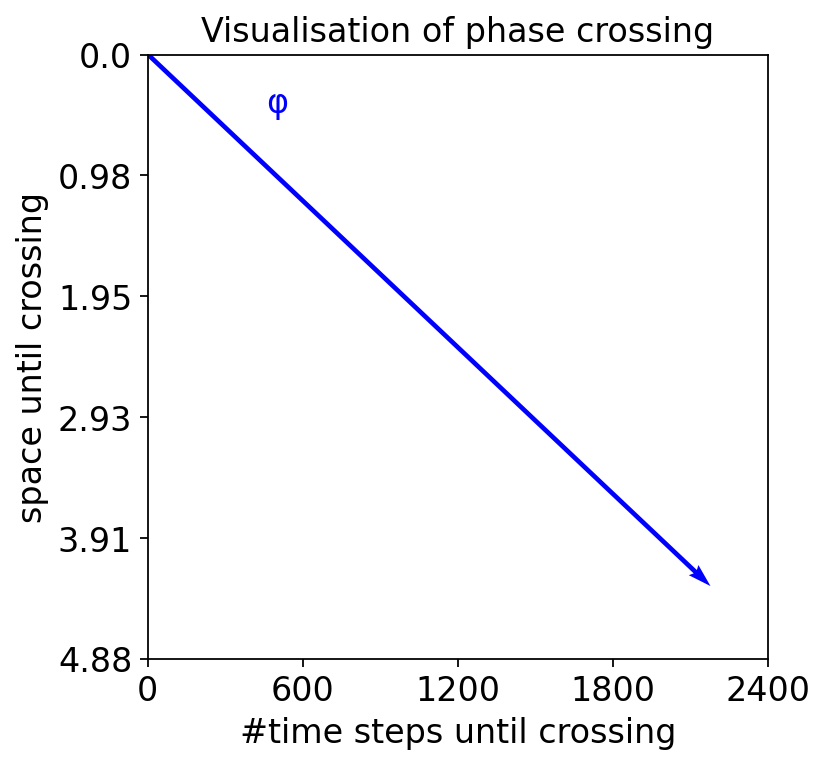

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=160)

ax.set_title('Visualisation of phase crossing', fontsize=15)

ax.quiver(0 , 0, 2178, -22, angles='xy', scale_units='xy', scale=1, color='b')

# Add angle label between arrow and x-axis
phi = np.arctan2(-22, 2178)  # Calculate angle in radians
phi_deg = np.degrees(phi)     # Convert angle to degrees

ax.text(500, -2, 'φ', ha='center', va='center', color='b', fontsize=15) #f'φ = {phi_deg:.2f}°',

#set x-axis labels
ax.set_xlabel('#time steps until crossing', fontsize=15)
ax.xaxis.set_major_locator(ticker.LinearLocator(5))
ax.set_xticklabels(labels=[0, 600, 1200, 1800, 2400], fontsize=15)
#set y-axis labels
ax.set_ylabel('space until crossing', fontsize=15)
ax.yaxis.set_major_locator(ticker.LinearLocator(6))
ax.set_yticklabels(labels=space_ticks[::-1], fontsize=15)


ax.set_xlim([-1, 2400])
ax.set_ylim([-25, 0])

In [205]:
len(ue.T[low,:])
time = ps.time[-start:-(start-duration)]

TypeError: slice indices must be integers or None or have an __index__ method

In [207]:
fig, ax = plt.subplots(1, 1, figsize=(30,4), dpi=160)

fs=25

low_steps = phase_latencies[low]
high_steps = phase_latencies[high-1]

start = 10 * 1000 * 10
duration = 0.45 * 1000 * 10

time = np.linspace(0, duration/(1000*10), 5)

space=np.linspace(-25, 25, 5)

acti_low = ue.T[low, -int(start):-int(start-duration)]
acti_high = ue.T[high, -int(start):-int(start-duration)]
time_axis = ps.time[-int(start):-int(start-duration)]
print(acti)

ax.plot(time_axis, acti_low, zorder=1, label='node #%i' %low, color = 'forestgreen')
ax.plot(time_axis, acti_high, zorder=1, label='node #%i' %int(high-1), color = 'deepskyblue')

ax.scatter(time_axis[int(2000+low_steps)], acti_low[int(2000+low_steps)], zorder=1, 
           facecolor='orange', edgecolor='red', s=250)
ax.scatter(time_axis[int(2000+high_steps)], acti_high[int(2000+high_steps)], zorder=1, 
           facecolor='orange', edgecolor='red', s=250)

ax.scatter(time_axis[int(2000)], acti_low[int(2000)], zorder=2, c='white', edgecolor='black', s=200)
ax.scatter(time_axis[int(2000)], acti_high[int(2000)], zorder=2, c='white', edgecolor='black', s=200)


ax.quiver(time_axis[int(2000)], acti_low[int(2000)], +low_steps*0.1, 0, 
          angles='xy', scale_units='xy', scale=1, color='forestgreen', width=0.001)
ax.quiver(time_axis[int(2000)], acti_high[int(2000)], +high_steps*0.1, 0, 
          angles='xy', scale_units='xy', scale=1, color='deepskyblue', width=0.005)

#set x-axis labels
ax.set_xlabel('time', fontsize=fs)
ax.xaxis.set_major_locator(ticker.LinearLocator(5))
ax.set_xticklabels(labels=time, fontsize=fs)


#set x-axis labels
ax.set_ylabel(r'$u_e([n_{%i}, n_{%i}],time)$' %(int(low), int(high-1)), fontsize=fs)
ax.yaxis.set_major_locator(ticker.LinearLocator(5))
ax.set_yticklabels(labels=[0, 0.25, 0.5, 0.75, 1], fontsize=fs)

ax.legend(loc='lower left', fontsize=fs)

[0.0072917  0.00392353 0.00241309 0.00169207 0.0013453  0.00120612
 0.00121596 0.00137943 0.00176787 0.00257442 0.00428145 0.00813965
 0.01756046 0.04205155 0.1063476  0.25705462 0.51167132 0.76106742
 0.90285911 0.96169635 0.9838894  0.99244311 0.99597565 0.99755683
 0.99831495 0.9986888  0.99885689 0.99888855 0.99879554 0.99854027
 0.99800871 0.99692006 0.99457065 0.98909933 0.97535732 0.93916044
 0.84656311 0.65110811 0.3814062  0.17055312 0.06748195 0.02707971
 0.01185072 0.00584375 0.00328758 0.00211344 0.00154633 0.00128026
 0.00119382 0.00125157 0.00147791 0.00197517 0.00300522 0.00522673
 0.01037856 0.02326376 0.05715853 0.14442112 0.33288967 0.60333431
 0.82084445 0.92895855 0.97159043 0.98764938 0.99396367 0.99664179
 0.99787123 0.99847023 0.99876279 0.99888108 0.99887215 0.99873201
 0.99840278 0.99772983 0.99633366 0.99324724 0.98586725 0.96694248
 0.91698366 0.79429845 0.56368103 0.29884476 0.12590058 0.04946027
 0.0203164  0.00923053 0.00475291 0.00279601 0.00187777 0.0014

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1723/2283111612.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=time, fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1723/2283111612.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=[0, 0.25, 0.5, 0.75, 1], fontsize=fs)


[0.0072917  0.00392353 0.00241309 0.00169207 0.0013453  0.00120612
 0.00121596 0.00137943 0.00176787 0.00257442 0.00428145 0.00813965
 0.01756046 0.04205155 0.1063476  0.25705462 0.51167132 0.76106742
 0.90285911 0.96169635 0.9838894  0.99244311 0.99597565 0.99755683
 0.99831495 0.9986888  0.99885689 0.99888855 0.99879554 0.99854027
 0.99800871 0.99692006 0.99457065 0.98909933 0.97535732 0.93916044
 0.84656311 0.65110811 0.3814062  0.17055312 0.06748195 0.02707971
 0.01185072 0.00584375 0.00328758 0.00211344 0.00154633 0.00128026
 0.00119382 0.00125157 0.00147791 0.00197517 0.00300522 0.00522673
 0.01037856 0.02326376 0.05715853 0.14442112 0.33288967 0.60333431
 0.82084445 0.92895855 0.97159043 0.98764938 0.99396367 0.99664179
 0.99787123 0.99847023 0.99876279 0.99888108 0.99887215 0.99873201
 0.99840278 0.99772983 0.99633366 0.99324724 0.98586725 0.96694248
 0.91698366 0.79429845 0.56368103 0.29884476 0.12590058 0.04946027
 0.0203164  0.00923053 0.00475291 0.00279601 0.00187777 0.0014

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1723/3227202117.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.linspace(-25,25,5), fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1723/3227202117.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=[0, 0.25, 0.5, 0.75, 1], fontsize=fs)


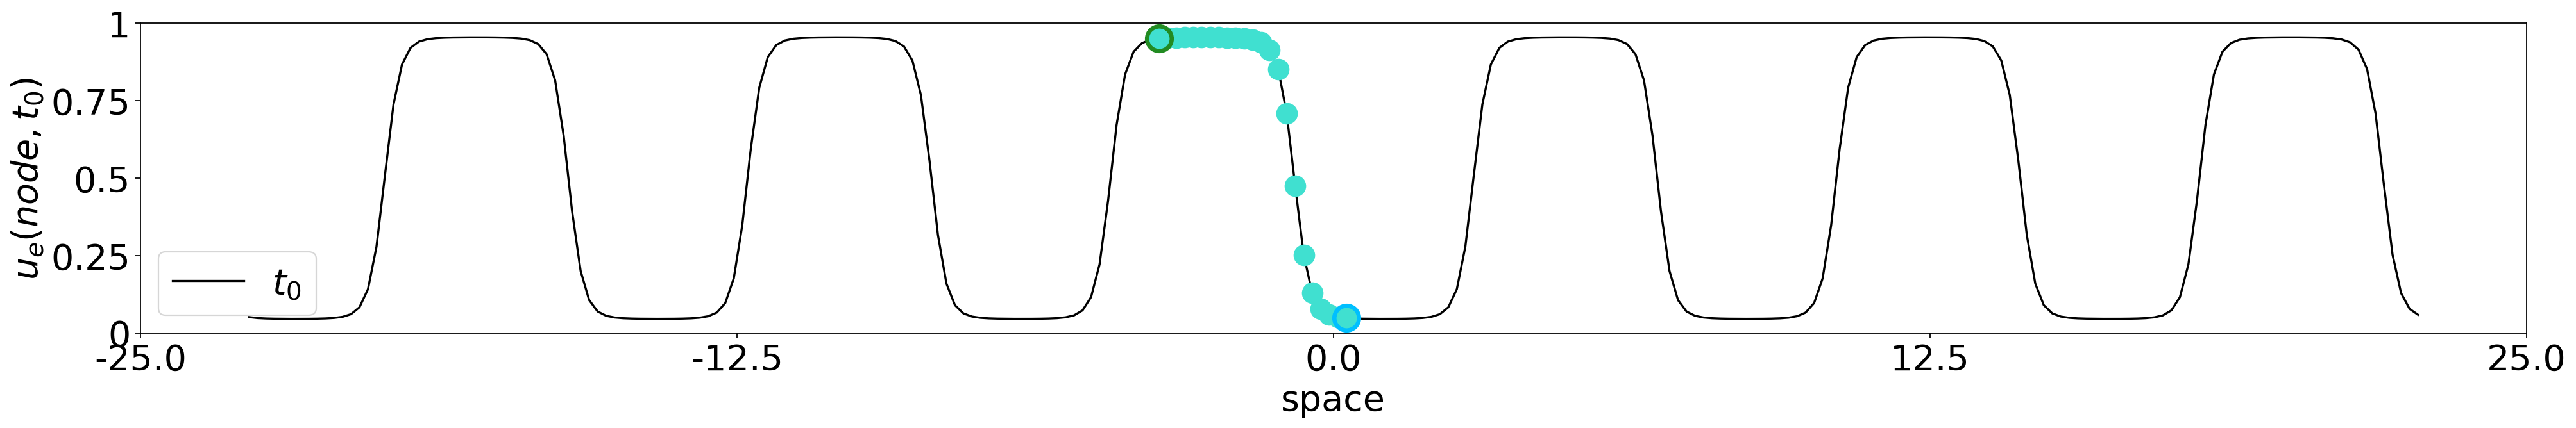

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(30,4), dpi=160)

fs=25
lw=3

low_steps = phase_latencies[low]
high_steps = phase_latencies[high-1]
amount_nodes = high-low

start = 10 * 1000 * 10
duration = 0.45 * 1000 * 10

time = np.linspace(0, duration/(1000*10), 5)

space=np.linspace(-25, 25, 5)

acti = ue.T[:, -int(start):-int(start-duration)]
acti = acti.T[int(2000+low_steps)] #plot the activity at time step t_0
space_axis = np.linspace(-25, 25, ps.n)
print(acti)

ax.plot(space_axis, acti, zorder=1, label=r'$t_0$', color = 'black')

ax.scatter(space_axis[low-10], acti[low-10], zorder=2, 
           facecolor='turquoise', edgecolor='forestgreen', s=300, linewidth=lw)
ax.scatter(space_axis[int(low-10+amount_nodes)], acti[int(low-10+amount_nodes)], zorder=2, 
           facecolor='turquoise', edgecolor='deepskyblue', s=300, linewidth=lw)

for ind in range(amount_nodes):
    
    ax.scatter(space_axis[int(low-10+ind)], acti[int(low-10+ind)], zorder=1, 
               color='turquoise', s=200)


#ax.quiver(space_axis[low], acti[low], space_axis[int(low+high)], 0, 
#          angles='xy', scale_units='xy', scale=1, color='black', width=0.001)

#set x-axis labels
ax.set_xlabel('space', fontsize=fs)
ax.xaxis.set_major_locator(ticker.LinearLocator(5))
ax.set_xticklabels(labels=np.linspace(-25,25,5), fontsize=fs)


#set x-axis labels
ax.set_ylabel(r'$u_e(node,t_0)$', fontsize=fs)
ax.yaxis.set_major_locator(ticker.LinearLocator(5))
ax.set_yticklabels(labels=[0, 0.25, 0.5, 0.75, 1], fontsize=fs)

ax.legend(loc='lower left', fontsize=fs)